In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics as st

np.set_printoptions(precision=2)

In [4]:
##Quarentine Measures
# Exponential Quarantine Function

def ExpQuarentine(d,lockdownday=20,effective=0.8, speed=0.05):
    dd=d
    val=0
    if d< lockdownday:
        val= 1 
    else:
        val= ((1-effective)+ effective*np.exp(- (d-lockdownday)*speed))
    
    return val


In [117]:
##Plotting Tools
#Set 

#Plot with variance
def var_plot(traj,ax1,last_d=None,color=[0, 102, 20]):
    plt.rcParams.update({'font.size': 16})
    
    rc=color[0]/255
    gc=color[1]/255
    bc=color[2]/255
    meantraj= curve_mean(traj)
    stdtraj = curve_std(traj)
    if last_d==None:
        last_d = min([len(meantraj),len(stdtraj)])
    x = np.arange(1, last_d, 1)
    y1 =np.asarray(meantraj[1:last_d]) + np.asarray(stdtraj[1:last_d])
    y2 =np.asarray(meantraj[1:last_d]) - np.asarray(stdtraj[1:last_d])
    y3= np.asarray(meantraj[1:last_d])

    ax1.fill_between(x, y1, y2, facecolor=(rc,gc,bc,0.3))
    ax1.plot(x,y3, color=(rc,gc,bc,1),linewidth=1)
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Days')

    ratio = 0.7
    xleft, xright = ax1.get_xlim()
    ybottom, ytop = ax1.get_ylim()
    ax1.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    
def var_plot2(traj,ax1,last_d=None,color=[0, 102, 20]):
    plt.rcParams.update({'font.size': 16})
    
    rc=color[0]/255
    gc=color[1]/255
    bc=color[2]/255
    meantraj= curve_mean(traj)
    stdtraj = curve_std(traj)
    if last_d==None:
        last_d = min([len(meantraj),len(stdtraj)])
    x = np.arange(1, last_d, 1)
    y1 =np.asarray(meantraj[1:last_d]) + np.asarray(stdtraj[1:last_d])
    y2 =np.asarray(meantraj[1:last_d]) - np.asarray(stdtraj[1:last_d])
    y3= np.asarray(meantraj[1:last_d])

    ax1.fill_between(x, y1, y2, facecolor=(rc,gc,bc,0.3))
    ax1.plot(x,y3, color=(rc,gc,bc,1),linewidth=1)
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Days')

    
    
#Plot many
def plot_many_trajectories(trajs, last_d=None):
    if last_d == None:
        last_d=len(trajs[0])
    plt.figure(figsize = (20,5));
    for t in trajs:
        plt.plot(range(1,last_d),t[1:last_d])
        
def plot_many_trajectories_ax(trajs,ax,last_d=None):
    if last_d == None:
        last_d=len(trajs[0])
    for t in trajs:
        ax.plot(range(1,last_d),t[1:last_d])

In [73]:
##Statistics Functions
def curve_mean(traj):
    return  [sum(col) / float(len(col)) for col in zip(*traj)]
def curve_std(traj):
    traja=np.asarray(traj)
    cmean=curve_mean(traj)
    dlen=len(cmean)
    
    std=[np.std(traja[:,i]) for i in range(0,dlen)]
    return std
    

In [74]:
#Simulation: 
#Takes Initial Susceptible, Initial Infected, Spread per day per person, 
#Recovery per day per person, max sim days, quarentine function
def SIR_sim(S0, I0, SR, RPDPP, d_end, quarentine):
    #Initialize
    SPDPP=SR/S0
    S=S0
    I=I0
    R=0
    d_final=d_end
    eventList=[1,2,3]

    S_d=[0 for i in range(0,d_end)]
    I_d=[0 for i in range(0,d_end)]
    R_d=[0 for i in range(0,d_end)]

    #SIR Loop

    #print("Running: ", d_end, end =" ")
    
    
    for d in range(1,d_end):
        stepsperday=max(20*int((SPDPP*S*I +RPDPP*I))+1,30)
        spreadrate= (SPDPP/stepsperday)*(quarentine[d])
        recrate=RPDPP/stepsperday


        for step in range(0,stepsperday):
            spreadprob=spreadrate*I*S # division by N is done in spreadrate calculation already in day loop
            recprob=recrate*I
            probevent=[1-spreadprob-recprob,spreadprob,recprob]
            #Error Catching to make sure my step sizes are small enough!
            if probevent[0]<0:
                print("negative prob! on day",d ," step ", step, ": ", probevent[0])
                print(S, I, R)
                break;

            event=random.choices(eventList,probevent)[0]
            if event==1:
                S=S
            elif event==2:
                S=S-1
                I=I+1
            elif event==3:
                I=I-1
                R=R+1

        #Record Values at end of day        
        S_d[d]=S
        I_d[d]=I
        R_d[d]=R

        #If all recovered, end simulation
        if R + S == S0+I0:
            d_final=d
            #print(S0, "Pandemic Ends on day",d_final," of ",d_end)
            for dd in range(d,d_end):
                R_d[dd]=R
                S_d[dd]=S
            break
            
    #print("\r----Final :",S,I,R)
    return S_d,I_d,R_d,d_final    

    
    


In [75]:
##Sim Loop For Agregate Data

def MultiSIRloop(S0=10000,I0=1, SR=3/14, RR=1/14, sims=10, maxdays=400, quar=None):
    if quar==None:
        quar=[1 for i in range(0, maxdays)]

    S_traj=[[0 for i in range(0,maxdays)] for j in range(0, sims)] 
    I_traj=[[0 for i in range(0,maxdays)] for j in range(0, sims)] 
    R_traj=[[0 for i in range(0,maxdays)] for j in range(0, sims)]
    daycount=[0 for j in range(0, sims)]

    for s in range(0,sims):
        S_traj[s], I_traj[s], R_traj[s],daycount[s]=SIR_sim(S0,I0,SR, RR, maxdays, quar)

    return S_traj, I_traj, R_traj, daycount, quar

def quick_means(S0=10000,I0=1, SR=3/14, RR=1/14, sims=1, maxdays=200):
    S, I, R, days, quar=MultiSIRloop(S0,I0, SR, RR, sims, maxdays)
    return S, I, R

def quick_infected(S0=10000,I0=1, SR=3/14, RR=1/14, sims=1, maxdays=200):
    S, I, R, days, quar=MultiSIRloop(S0, I0, SR, RR, sims, maxdays)
    return I


# Simulation for city of 10k, no lock down #

In [161]:
md=400
my_quar=[ExpQuarentine(d) for d in range(0,md)]
S, I, R, days, quar= MultiSIRloop(sims=100, maxdays=md,S0=10000,SR=3/14, I0=20)

Avg death:  242


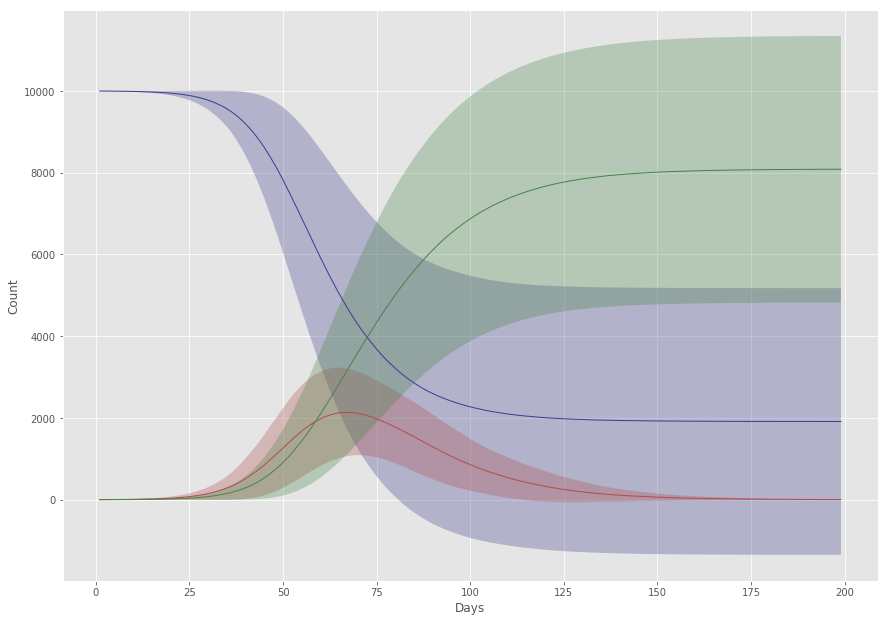

In [157]:
#print results
last_days=200#min(days)
fig_mine, (ax_mine) = plt.subplots(1, 1, sharex=True)
fig_mine.set_size_inches(18.5, 10.5)
    
var_plot(S,ax_mine, last_d=last_days,color=[61, 61, 142]) #blue
var_plot(I,ax_mine,last_d=last_days,color=[178, 76, 76]) #red
var_plot(R,ax_mine, last_d=last_days,color=[71, 132, 71]) #green

#plt.plot(range(1,last_days),10000*np.asarray(quar.copy())[1:last_days], color='gray', linewidth=2);
#plt.title('SIR Curves with 1σ bounds, I(0)=20, R0=3',fontsize=15)

maxrec=[]
for r in R:
    maxrec.append(max(r))
print("Avg death: ", int(0.03*np.mean(maxrec)))

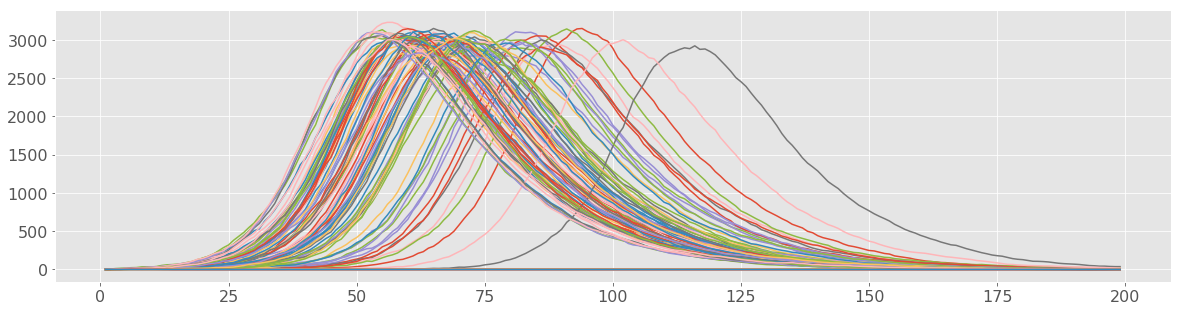

In [158]:

plot_many_trajectories(I, last_d=200)
#plt.title('All Trajectories',fontsize=15)


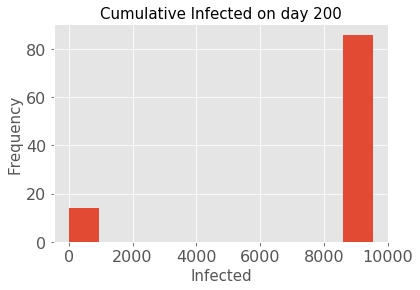

In [159]:
final_r=[R[i][200] for i in range(0,100)]
plt.hist(final_r,bins=10)
plt.style.use('ggplot')
plt.xlabel('Infected',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Cumulative Infected on day 200',fontsize=15)
plt.show()

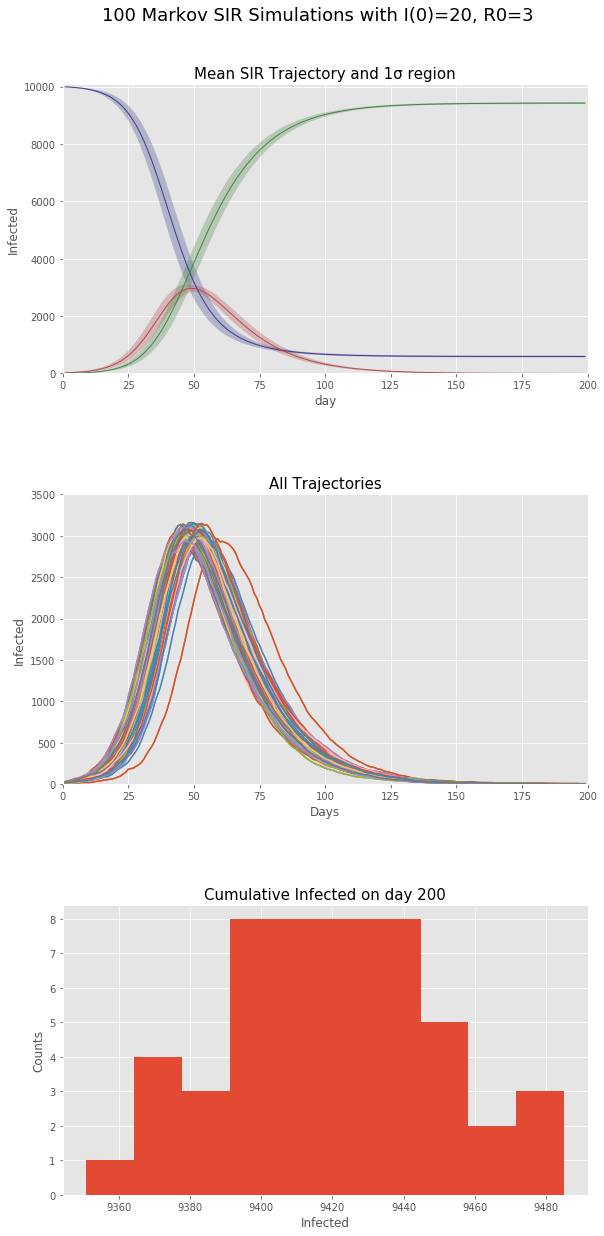

In [162]:
last_days=200#min(days)
fig_mine, ax = plt.subplots(3, 1, sharex=False)
fig_mine.set_size_inches(10.5, 18.5)
fig_mine.tight_layout(pad=10.0)
    
#var_plot(S,ax_mine, last_d=last_days,color=[61, 61, 142]) #blue
#var_plot(I,ax_mine,last_d=last_days,color=[178, 76, 76]) #red
#var_plot(R,ax_mine, last_d=last_days,color=[71, 132, 71]) #green
plt
#plt.plot(range(1,last_days),10000*np.asarray(quar.copy())[1:last_days], color='gray', linewidth=2);
fig_mine.suptitle('100 Markov SIR Simulations with I(0)=20, R0=3',fontsize=18)

var_plot2(S,ax[0], last_d=last_days,color=[61, 61, 142]) #blue
var_plot2(I,ax[0],last_d=last_days,color=[178, 76, 76]) #red
var_plot2(R,ax[0], last_d=last_days,color=[71, 132, 71]) #green
ax[0].set_title('Mean SIR Trajectory and 1σ region',fontsize=15)
ax[0].set_xlim([0, 200])
ax[0].set_ylim([0, 10100])
ax[0].set(xlabel='day', ylabel='Infected')

plot_many_trajectories_ax(I,ax[1], last_d=200)
plot_many_trajectories_ax(I,ax[1], last_d=200)
ax[1].set_title('All Trajectories',fontsize=15)
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 3500])
ax[1].set(xlabel='Days', ylabel='Infected')




final_r=[R[i][200] for i in range(0,50)]
ax[2].set_title('Cumulative Infected on day 200',fontsize=15)
#ax[2].set_xlim([min(final_r), max(final_r)])
#ax[2].set_ylim([0, 50])
ax[2].set(xlabel='Infected', ylabel='Counts')

ax[2].hist(final_r,bins=10)


    
plt.style.use('ggplot')

# Simulation for city of 10k, moderate lock down #

In [14]:
md=800
my_quar=[ExpQuarentine(d,effective=0.5,speed=2) for d in range(0,md)]
Sq, Iq, Rq, daysq, quarq= MultiSIRloop(sims=20, maxdays=md,SR=3/14, S0=10000, I0=2,quar=my_quar)

Avg death:  130


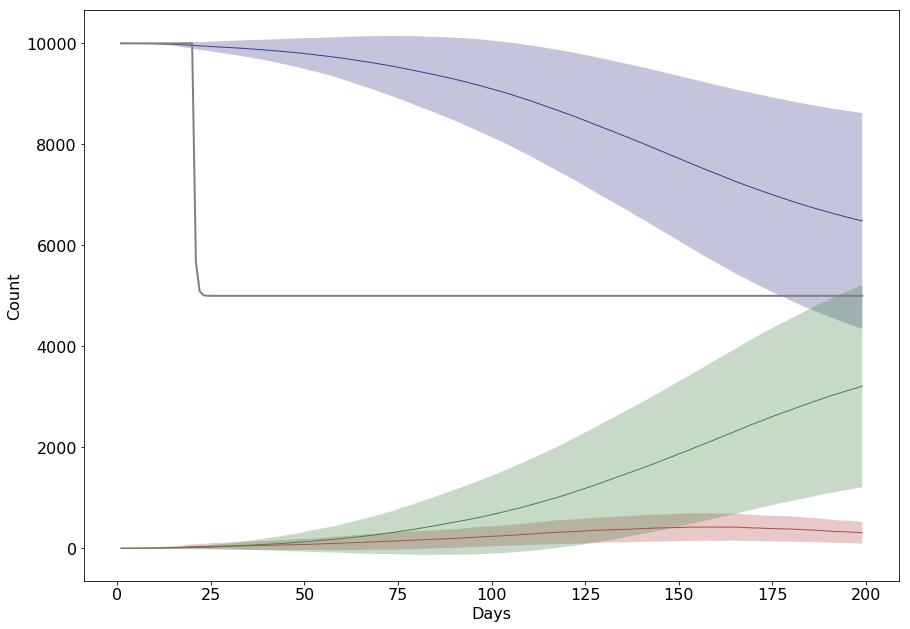

In [15]:
last_days=200#int(st.mean(daysq))
#print(last_days)
fig_mine2, (ax_mine2) = plt.subplots(1, 1, sharex=True)
fig_mine2.set_size_inches(18.5, 10.5)
    
var_plot(Sq,ax_mine2, last_d=last_days,color=[61, 61, 142]) #blue
var_plot(Iq,ax_mine2,last_d=last_days,color=[178, 76, 76]) #red
var_plot(Rq,ax_mine2, last_d=last_days,color=[71, 132, 71]) #green

plt.plot(range(1,last_days),10000*np.asarray(quarq.copy())[1:last_days], color='gray', linewidth=2);

del maxrec
maxrec=[]
for rr in Rq:
    maxrec.append(max(rr))
print("Avg death: ", int(0.03*np.mean(maxrec)))

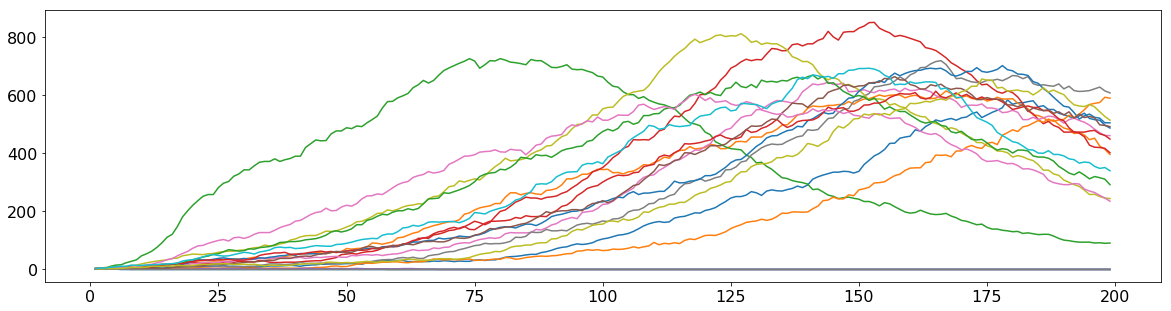

In [16]:
plot_many_trajectories(Iq, last_d=200)

In [79]:
print(Rq)
print(max(Rq[0]))

[[0, 1, 2, 2, 4, 5, 6, 8, 12, 14, 15, 21, 25, 28, 29, 34, 35, 45, 56, 63, 69, 78, 90, 106, 128, 141, 157, 171, 185, 199, 215, 230, 253, 268, 291, 318, 339, 364, 388, 416, 444, 471, 499, 529, 562, 598, 621, 659, 692, 709, 743, 783, 813, 850, 889, 920, 949, 984, 1025, 1067, 1102, 1146, 1189, 1237, 1294, 1348, 1396, 1435, 1478, 1534, 1579, 1628, 1681, 1740, 1787, 1829, 1870, 1912, 1964, 2028, 2084, 2131, 2184, 2232, 2281, 2330, 2379, 2435, 2487, 2557, 2619, 2663, 2714, 2767, 2821, 2876, 2923, 2981, 3015, 3059, 3095, 3136, 3181, 3219, 3253, 3290, 3332, 3378, 3419, 3448, 3490, 3534, 3568, 3607, 3653, 3696, 3744, 3796, 3837, 3877, 3914, 3973, 4017, 4053, 4087, 4130, 4174, 4213, 4259, 4293, 4333, 4378, 4418, 4456, 4490, 4521, 4549, 4572, 4602, 4639, 4675, 4714, 4741, 4766, 4797, 4827, 4858, 4884, 4916, 4949, 4985, 5012, 5041, 5071, 5095, 5122, 5146, 5164, 5186, 5216, 5235, 5256, 5277, 5294, 5320, 5339, 5357, 5381, 5399, 5416, 5433, 5457, 5477, 5496, 5515, 5529, 5540, 5554, 5562, 5578, 5588, 5

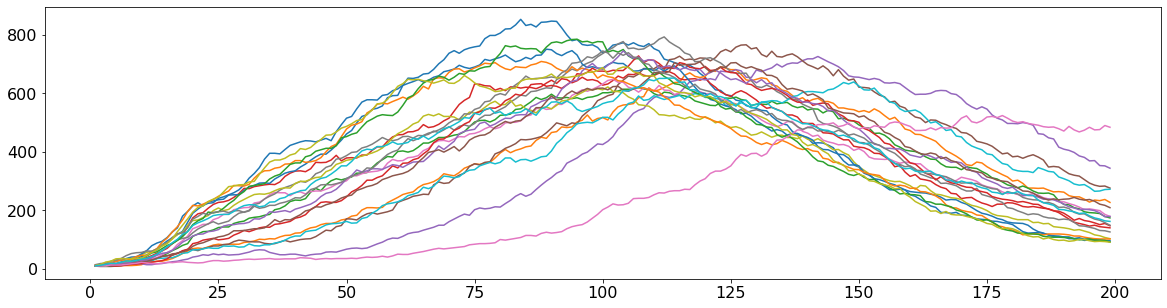

In [18]:
plot_many_trajectories(Iq, last_d=200)